In [ ]:
!pip install kornia

Mounted at /content/drive


In [ ]:
! rm -r tensors

In [98]:
# IMPORT LIBRARIES

import os
import subprocess
import numpy as np
import re
import shutil
import random
import matplotlib.pyplot as plt
import time
import gc
from google.colab import files


# image processing
from PIL import Image, ImageCms
from kornia.color import rgb_to_lab, lab_to_rgb
import cv2
from skimage import color, io
from skimage.transform import resize

#Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading the Data

The data we are using is a subset of the original SUN397 dataset found at https://vision.princeton.edu/projects/2010/SUN/. In order to make this subset of the data, we have choose the classes related to urban scenary. In total this amounts for 12950 images with 32 different classes in total.

The following function has been used to create this dataset where classes.txt is a file that indicates which classes we choose from the original SUN397 dataset.

In [ ]:
# The following function has be

folder_path = "./SUN-dataset"
SUN397_path = "./datasets/SUN397"
categories_path = "./datasets/classes.txt"
#class_subset = 0.1


def create_SUN_subset(folder_path, SUN397_path, categories_path, class_subset):

    if not os.path.exists(folder_path):   #create dataset main directory
        os.makedirs(folder_path)

    all_items=os.listdir(SUN397_path)

    directories = np.sort([item for item in all_items if os.path.isdir(os.path.join(SUN397_path, item))])

    with open(categories_path) as f:
        categories = f.read().replace("\n", "").split(", ")

    for letter in directories:

        indices = np.where(np.array([word[0] == letter for word in categories]))[0]

        filtered_categories = [categories[i] for i in indices]

        for category in filtered_categories:

#            destination_path = f"{folder_path}/{letter}/{category}"
            source_path = f"{SUN397_path}/{letter}/{category}"

#            if not os.path.exists(destination_path):
#                os.makedirs(destination_path)

            img_instances = os.listdir(source_path)
            max_instances = int(class_subset*len(img_instances))

            for i in range(max_instances):

                img_indx = random.randint(0, len(img_instances)-1)
                img_sample = img_instances[img_indx]


                source_file = os.path.join(source_path, img_sample)

                new_filename = "{}{}".format(category.split("/")[0], i+1)

                destination_file = os.path.join(folder_path, new_filename)
                shutil.copy(source_file, destination_file)

                img_instances.remove(img_sample)


#create_SUN_subset(folder_path=folder_path, SUN397_path=SUN397_path, categories_path=categories_path, class_subset=class_subset)



We have stored the resulting dataset in Google Drive so we can upload when working with colab as follows. Additionally the naming of the images has been changed to include the class (e.g. ClassName123).

In [ ]:
# DOWNLOAD DATA

!rm -r ./SUN-dataset/

#file_id = "1EqJ-7Cl2Fgt8mVP0BvLHnQzY4WiSNr63"    # SUN

file_id = "1ay9DuTk3Hz1wCbbvdJjR4b3My5QAEwKT"    #reduced


!gdown --id $file_id

!tar -xvf  'SUN-dataset-reduced.tar.xz'

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ay9DuTk3Hz1wCbbvdJjR4b3My5QAEwKT
From (redirected): https://drive.google.com/uc?id=1ay9DuTk3Hz1wCbbvdJjR4b3My5QAEwKT&confirm=t&uuid=dad871b2-87fc-40d3-9c59-4179e91d144b
To: /content/SUN-dataset-reduced.tar.xz
100% 503M/503M [00:01<00:00, 274MB/s]
SUN-dataset/
SUN-dataset/alley1
SUN-dataset/alley2
SUN-dataset/alley3
SUN-dataset/alley4
SUN-dataset/alley5
SUN-dataset/alley6
SUN-dataset/alley7
SUN-dataset/alley8
SUN-dataset/alley9
SUN-dataset/alley10
SUN-dataset/alley11
SUN-dataset/alley13
SUN-dataset/alley14
SUN-dataset/alley15
SUN-dataset/alley16
SUN-dataset/alley17
SUN-dataset/alley18
SUN-dataset/alley19
SUN-dataset/alley20
SUN-dataset/alley23
SUN-dataset/alley24
SUN-dataset/alley25
SUN-dataset/alley26
SUN-datas

We need to remove a small fraction of the images that are not encoded correctly as they do not have the 3 channels of an RGB image.

In [ ]:

folder_path = "./SUN-dataset/"

def detect_non_standard_images(folder_path):

  img_remove = []

  for file_name in os.listdir(folder_path):

    file_path = os.path.join(folder_path, file_name)
    img = Image.open(file_path)
    if len(img.getbands()) != 3:
      img_remove.append(file_name)

  return img_remove

def remove_non_standard_images(folder_path, img_list):
  for file_name in img_list:
    file_path = os.path.join(folder_path, file_name)
    try:
      subprocess.run(["rm", file_path])
      print(f"Removed image {file_name} succesfully")
    except FileNotFoundError:
      pass

image_list = detect_non_standard_images(folder_path=folder_path)
print(image_list)

remove_non_standard_images(folder_path=folder_path, img_list=image_list)

['bow_window5', 'skyscraper56', 'cathedral24']
Removed image bow_window5 succesfully
Removed image skyscraper56 succesfully
Removed image cathedral24 succesfully


Now we to perform a split of the data into training, validation and testing. This is done to have a good balance of classes while performing the training, validation and testing. In our case we performed a 80-10-10 split.

In [ ]:
def get_image_class(filename):
    pattern = r'[0-9]'
    return re.sub(pattern, '', filename)


!rm -r train-split val-split test-split
! mkdir train-split val-split test-split

folder_path="./SUN-dataset"
train_path = "./train-split"
val_path = "./val-split"
test_path = "./test-split"
data_split = [0.8, 0.1, 0.1]

def data_folder_split(folder_path, train_path, val_path, test_path, data_split):


  dict_files = {}

  folders = [train_path, val_path, test_path]


  for file in os.listdir(folder_path):
    file_class = get_image_class(file)
    if file_class not in dict_files:
      dict_files[file_class] = [file]
    else:
      dict_files[file_class].append(file)

  for key in dict_files.keys():
    total = len(dict_files[key])
    train = int(total*data_split[0])
    val = int((total-train)/2)
    test = total - train - val

    train_files = random.sample(dict_files[key], train)
    dict_files[key] = list(set(dict_files[key]) - set(train_files))

    val_files = random.sample(dict_files[key], val)
    dict_files[key] = list(set(dict_files[key]) - set(val_files))
    test_files = dict_files[key]

    file_data = [train_files, val_files, test_files]

    for i in range(len(file_data)):
      for data in file_data[i]:
        source_file = os.path.join(folder_path, data)
        destination_file = os.path.join(folders[i], data)
        shutil.copy(source_file, destination_file)

data_folder_split(folder_path=folder_path, train_path=train_path,
                  val_path=val_path, test_path=test_path, data_split=data_split)


# Creating the training, validation and testing datasets.

We create a custom Dataset Class that store the images of the SUN-dataset folder

In [ ]:
class ModelData(Dataset):

    def __init__(self, folder_path, transform=None):

        self.folder_path = folder_path
        self.data = os.listdir(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_name = self.data[idx]
        file_path = os.path.join(self.folder_path, file_name)

        image = Image.open(file_path)

        image = image.resize((256, 256))

        image = np.array(image)/255

        image = color.rgb2lab(image)

        image = np.transpose(image, (2, 0, 1))

        image[0] = image[0]/50 -1
        image[1:] = ((image[1:] + 128)*2 - 255) / (255)

        return torch.tensor(image)

#        if self.transform:

#            img = self.transform(img)

#        return img, file_name


While doing that we apply a transformation to the data so they all have the same dimensions. For every training, validation, testing dataset we will define a dataloader that is used as the input to our model

In [ ]:
train_path = "./train-split"
val_path = "./val-split"
test_path = "./test-split"

target_width, target_height = 256, 256
batch_size = 64


#transform = transforms.Compose([
#    transforms.Resize((target_width, target_height)),
#    transforms.ToTensor(),
#])

# Create datasets and DataLoaders
train_dataset = ModelData(train_path, transform=None, )
val_dataset = ModelData(val_path, transform=None)
test_dataset = ModelData(test_path, transform=None)

# dataset = ModelData(folder_path, transform=transform)
#train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
#    dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))
#



train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



Let's see if the dataset has been processed correctly by visualizing one sample of each split.

In [ ]:
print( f"Train Dataset Size: {len(train_dataset)} \nValidation Dataset Size: {len(val_dataset)}\nTest Dataset Size: {len(test_dataset)}")

Train Dataset Size: 1011 
Validation Dataset Size: 123
Test Dataset Size: 146


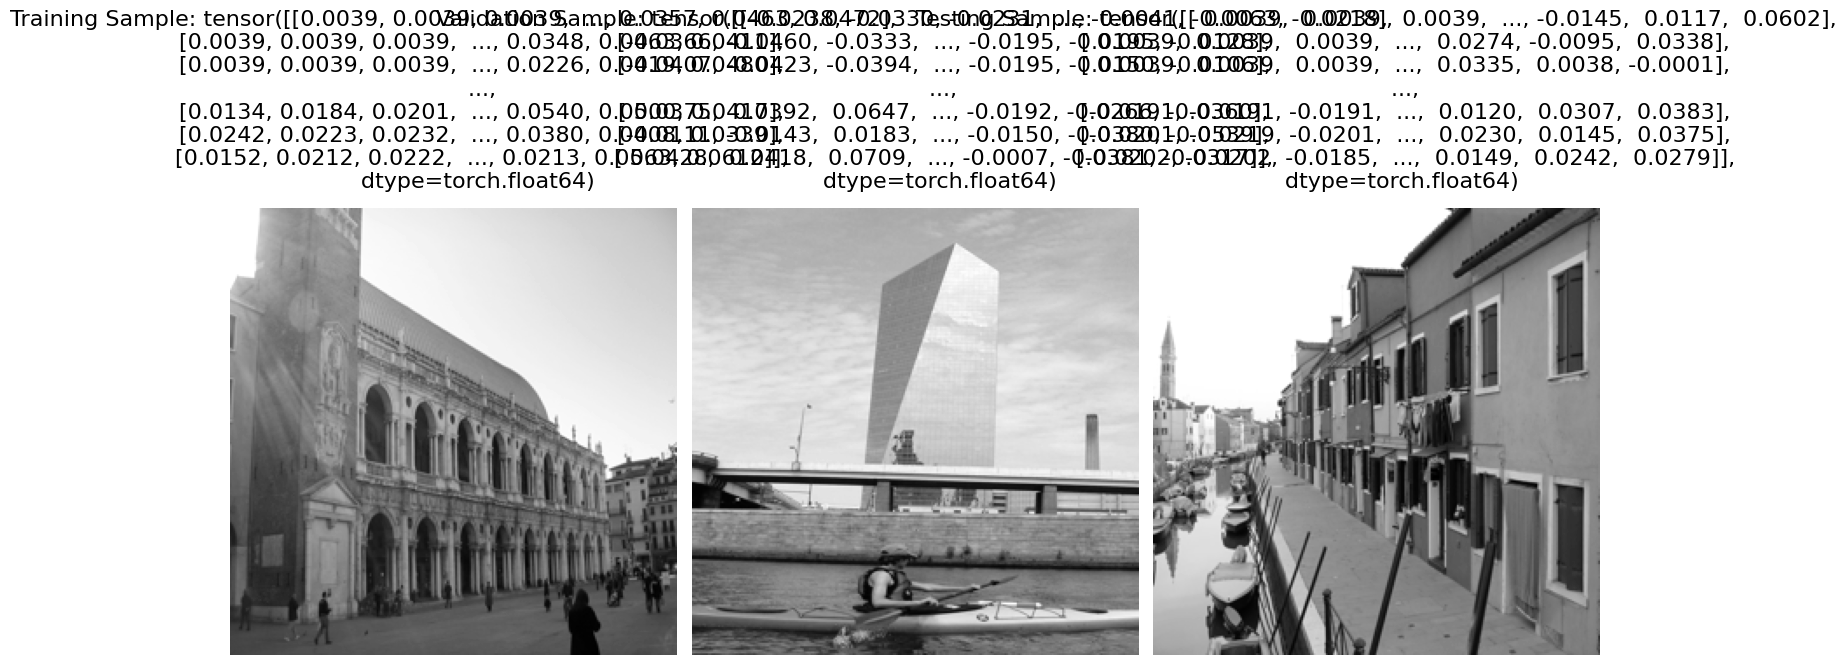

In [ ]:
train_sample = train_dataset[0][0]
val_sample = val_dataset[0][0]
test_sample = test_dataset[0][0]

plt.figure(figsize=(14, 8))

plt.subplot(1, 3, 1)
plt.imshow(train_sample, cmap="gray")
plt.title(f'Training Sample: {train_dataset[0][1]}', fontsize=16, pad=15)
plt.axis("off")


plt.subplot(1, 3, 2)
plt.imshow(val_sample, cmap="gray")
plt.title(f'Validation Sample: {val_dataset[0][1]}', fontsize=16, pad=15)
plt.axis("off")


plt.subplot(1, 3, 3)
plt.imshow(test_sample, cmap="gray")
plt.title(f'Testing Sample: {test_dataset[0][1]}', fontsize=16, pad=15)
plt.axis("off")


plt.tight_layout()

# Autoencoder Model

In [ ]:
class ImgEncoder(nn.Module):

    def __init__(self):
        super(ImgEncoder, self).__init__()

        self.layers = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            # Conv2
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            # Conv3
            nn.Conv2d(128, 128, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            # Conv4
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            # Conv5
            nn.Conv2d(256, 256, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            # Conv6
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            # Conv7
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            # Conv8
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
class ImgDecoder(nn.Module):

    def __init__(self):
        super(ImgDecoder, self).__init__()

        self.layers = nn.Sequential(

            # Conv1
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            # Upsample1
            nn.Upsample(scale_factor=2.0),

            # Conv2
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            # Conv3
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            # Upsample2
            nn.Upsample(scale_factor=2.0),

            # Conv4
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            # Conv5
            nn.Conv2d(32, 2, 3, stride=1, padding=1),
            nn.Tanh(),

            # Upsample3
            nn.Upsample(scale_factor=2.0),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
class ColorNet(nn.Module):

    def __init__(self):
        super(ColorNet, self).__init__()
        self.encoder = ImgEncoder()
        self.decoder = ImgDecoder()
        #self.post_fuse = nn.Conv2d(1256, 256, 1, stride=1, padding=0)
        #self.relu = nn.ReLU(inplace=True)

    def forward(self, img1):

        # Encoder Output
        out_enc = self.encoder(img1)

        # Fusion
        #temp = self.fusion(out_enc, img2)
        #temp = self.post_fuse(temp)
        #temp = self.relu(temp)

        return self.decoder(out_enc)

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ColorNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
criterion = nn.MSELoss().to(device)

In [100]:
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

Number of parameters: 6257954


In [ ]:
print(model)

ColorNet(
  (encoder): ImgEncoder(
    (layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU(inplace=True)
      (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): BatchNorm2d(256

Because the amount of computational time needed to process the data we will use a set of tensor files of the same data.

In [ ]:
class ModelData(torch.utils.data.Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_name = self.data[idx]
        file_path = os.path.join(self.root_dir, file_name)
        img_tensor = torch.load(file_path)
        return img_tensor

In [77]:
os.chdir("/content")

# concatenate the files

!cat ./drive/MyDrive/tensors/tensors.zip* > tensors.zip

! unzip tensors.zip

Streaming output truncated to the last 5000 lines.
  inflating: tensors/data5499        
  inflating: tensors/data55          
  inflating: tensors/data550         
  inflating: tensors/data5500        
  inflating: tensors/data5501        
  inflating: tensors/data5502        
  inflating: tensors/data5503        
  inflating: tensors/data5504        
  inflating: tensors/data5505        
  inflating: tensors/data5506        
  inflating: tensors/data5507        
  inflating: tensors/data5508        
  inflating: tensors/data5509        
  inflating: tensors/data551         
  inflating: tensors/data5510        
  inflating: tensors/data5511        
  inflating: tensors/data5512        
  inflating: tensors/data5513        
  inflating: tensors/data5514        
  inflating: tensors/data5515        
  inflating: tensors/data5516        
  inflating: tensors/data5517        
  inflating: tensors/data5518        
  inflating: tensors/data5519        
  inflating: tensors/data552         

In [79]:
class ModelData(torch.utils.data.Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_name = self.data[idx]
        file_path = os.path.join(self.root_dir, file_name)
        img_tensor = torch.load(file_path)
        return img_tensor

dataset = ModelData(root_dir="./tensors", transform = None )

In [91]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))

In [94]:
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle = True,
                                             num_workers=2)
val_iterator = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                         )



In [102]:
def train(model, iterator, optimizer, criterion, device):

  epoch_loss = 0

  # Apply train mode
  model.train()

  for data in iterator:

    enc_in = data["L_enc"].to(device)
    AB = data["AB"].to(device)

    optimizer.zero_grad()

    prediction = model(enc_in)

    # Compute loss
    loss = criterion(prediction, AB)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()


  return epoch_loss/len(iterator)

In [90]:
def evaluate(model, iterator, criterion, device):

  epoch_loss = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for data in iterator:

      enc_in = data["L_enc"].to(device)
      AB = data["AB"].to(device)

      # Make Predictions
      prediction = model(enc_in)

      # Compute loss
      loss = criterion(prediction, AB)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()

  return epoch_loss/len(iterator)

In [92]:
def format_model_name(base_name, loss):
    return f'{base_name}_{loss:.4f}'.replace(".", "_") + ".pt"

In [103]:
def model_training(n_epochs, model, train_iterator, val_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Initialize validation loss
    best_valid_loss = float('inf')

  # Save output losses, accs
    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # train
        train_loss = train(model, train_iterator, optimizer, criterion, device)

        valid_loss = evaluate(model, val_iterator, criterion, device)

        # Save best model

        if valid_loss < best_valid_loss:

            best_valid_loss = valid_loss
            best_model_name = format_model_name(model_name,best_valid_loss)
            # Save model
            torch.save(model.state_dict(), model_name)

        end_time = time.time()

        print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
        print("---------------------------------")
        print(f"Train -- Loss: {train_loss:.3f}")
        print(f"Val -- Loss: {valid_loss:.3f}")

        # Save
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        torch.cuda.empty_cache()
        _ = gc.collect()

    return train_losses, valid_losses, best_model_name

In [104]:
train_loss, val_loss, model_name = model_training(n_epochs=25, model=model, train_iterator=train_iterator,
                                      val_iterator=val_iterator, optimizer=optimizer,
                                      criterion=criterion, device=device,
                                      model_name="colornet_baseline")

#files.download(model_name)


Epoch: 1/25 -- Epoch Time: 166.00 s
---------------------------------
Train -- Loss: 0.010
Val -- Loss: 0.013

Epoch: 2/25 -- Epoch Time: 160.28 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.014

Epoch: 3/25 -- Epoch Time: 160.73 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.010

Epoch: 4/25 -- Epoch Time: 161.56 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.013

Epoch: 5/25 -- Epoch Time: 162.92 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.011

Epoch: 6/25 -- Epoch Time: 160.65 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.009

Epoch: 7/25 -- Epoch Time: 160.56 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.009

Epoch: 8/25 -- Epoch Time: 161.13 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.009

Epoch: 9/25 -- Epoch Time: 162.06 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.009



FileNotFoundError: Cannot find file: colornet_baseline_0_0080.pt

# CNN Model

In [135]:
# HourGlass CNN Model

class HourglassCNN(nn.Module):
    def __init__(self):
        super(HourglassCNN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),  # Output: 128x128x64
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),  # Output: 64x64x128
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),  # Output: 32x32x256
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 64x64x128
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 128x128x64
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=2, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 256x256x2
            nn.Tanh()  # Assuming the output is expected to be in the range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [136]:
# Initialize the network

model = HourglassCNN().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss().to(device)

In [137]:
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

Number of parameters: 740802


In [138]:
print(model)

HourglassCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Tanh()
  )
)


In [139]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))

In [140]:
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle = True,
                                             num_workers=2)
val_iterator = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                         )



In [141]:
train_loss, val_loss, model_name = model_training(n_epochs=25, model=model, train_iterator=train_iterator,
                                      val_iterator=val_iterator, optimizer=optimizer,
                                      criterion=criterion, device=device,
                                      model_name="Hourglass")



Epoch: 1/25 -- Epoch Time: 49.03 s
---------------------------------
Train -- Loss: 0.011
Val -- Loss: 0.010

Epoch: 2/25 -- Epoch Time: 48.07 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.010

Epoch: 3/25 -- Epoch Time: 48.52 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.010

Epoch: 4/25 -- Epoch Time: 48.50 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.009

Epoch: 5/25 -- Epoch Time: 48.29 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.009

Epoch: 6/25 -- Epoch Time: 48.53 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.009

Epoch: 7/25 -- Epoch Time: 48.09 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.009

Epoch: 8/25 -- Epoch Time: 48.43 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.009

Epoch: 9/25 -- Epoch Time: 48.35 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.008

Epoch: 10

# CNN Model

In order to perform Image colorization we are going to use the Colorful image Colorization CNN model that was one of the first CNN models to colorize grayscale images.

The architecture of the model is as follows: The network stacks convolutional layers in a linear fashion, forming eight blocks. Each block is made
up of either two or three convolutional layers followed by a ReLU layer and a Batch Normalization
layer. Striding, instead of pooling, is used to decrease the size of the image. The input to the network is $256 \times 256$, while the output is $224 \times 224$; however, it is resized later to
the original image size.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from IPython import embed

#from .base_color import *

class ECCVGenerator(nn.Module):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
#        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
 #       model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
#        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
#        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
#        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
#        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
#        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1_2 = self.model1(input_l)
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.upsample4(out_reg)



In [ ]:
model = ECCVGenerator().to(device).to(torch.double)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
criterion = nn.MSELoss().to(device)

In [ ]:
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

Number of parameters: 32231019


In [ ]:
print(model)

ECCVGenerator(
  (model1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (model2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (model3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (model4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3

In [ ]:
def load_img(img_path):
	out_np = np.asarray(Image.open(img_path))
	if(out_np.ndim==2):
		out_np = np.tile(out_np[:,:,None],3)
	return out_np

def resize_img(img, HW=(256,256), resample=3):
	return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

def preprocess_img(img_rgb_orig, HW=(256,256), resample=3):
	# return original size L and resized L as torch Tensors
	img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)

	img_lab_orig = color.rgb2lab(img_rgb_orig)
	img_lab_rs = color.rgb2lab(img_rgb_rs)

	img_l_orig = img_lab_orig[:,:,0]
	img_l_rs = img_lab_rs[:,:,0]

	tens_orig_l = torch.Tensor(img_l_orig)[None,None,:,:]
	tens_rs_l = torch.Tensor(img_l_rs)[None,None,:,:]

	return (tens_orig_l, tens_rs_l)

In [ ]:
next(iter(train_dataloader))

tensor([[[[-4.2107e-01, -1.9948e-01, -4.1722e-01,  ...,  5.5491e-02,
            5.3310e-02,  5.3310e-02],
          [-9.4146e-01, -6.0423e-01, -2.4383e-01,  ...,  6.1011e-02,
            6.1011e-02,  6.1011e-02],
          [-9.8516e-01, -9.8194e-01, -7.6753e-01,  ...,  5.5491e-02,
            6.8704e-02,  6.8704e-02],
          ...,
          [ 4.7719e-01,  5.0263e-01,  6.1436e-01,  ...,  2.0097e-01,
            2.4755e-01,  2.8510e-01],
          [ 7.3182e-01,  7.0004e-01,  6.5338e-01,  ...,  6.7184e-02,
            7.2322e-02,  5.8988e-02],
          [ 8.9513e-01,  8.9361e-01,  7.9528e-01,  ...,  4.2794e-02,
            4.0325e-02,  6.5589e-02]],

         [[ 1.9937e-01,  2.2892e-01,  1.7488e-01,  ...,  8.2226e-02,
            7.7932e-02,  7.7932e-02],
          [ 6.9879e-02,  1.0556e-01,  1.7656e-01,  ...,  7.7499e-02,
            7.7499e-02,  7.7499e-02],
          [ 9.9441e-03,  3.6867e-02,  1.4784e-01,  ...,  8.2226e-02,
            7.7072e-02,  7.7072e-02],
          ...,
     

In [ ]:
def train(model, dataloader, optimizer, criterion, device):

  epoch_loss = 0

  # Apply train mode
  model.train()

  for data in dataloader:

    L_data = data[:, 0, :, :].unsqueeze(1).to(device)
    AB_data = data[:, 1:, :, :].to(device)


    optimizer.zero_grad()

    prediction = model(L_data)

    # Compute loss
    loss = criterion(prediction, AB_data)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()


  return epoch_loss/len(dataloader)

In [ ]:
def model_training(n_epochs, model, train_dataloader, val_dataloader, optimizer, criterion, device, model_name):

  # Initialize validation loss
    best_valid_loss = float('inf')

  # Save output losses, accs
    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        start_time = time.time()
        print("a")
        # train
        train_loss = train(model, train_dataloader, optimizer, criterion, device)
        valid_loss = evaluate(model, val_dataloader, criterion, device)

        print("b")
        # Save best model

        if valid_loss < best_valid_loss:

            best_valid_loss = valid_loss
            # Save model
            torch.save(model.state_dict(), model_name)

        end_time = time.time()

        print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
        print("---------------------------------")
        print(f"Train -- Loss: {train_loss:.3f}")
        print(f"Val -- Loss: {valid_loss:.3f}")

        # Save
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        torch.cuda.empty_cache()
        _ = gc.collect()

    return train_losses, valid_losses

In [ ]:
torch.cuda.empty_cache()
gc.collect()


7618

In [ ]:
train_loss, val_loss = model_training(n_epochs=5, model=model, train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader, optimizer=optimizer,
                                      criterion=criterion, device=device,
                                      model_name="./best-model.pth")

In [ ]:
epochs = 10

train_batch_loss = []
train_epoch_loss = []

val_batch_loss = []
val_epoch_loss = []


for epoch in range(epochs):

    start_time = time.time()
    train_total_loss = 0
    val_total_loss = 0
    model.train()
    # Train
    for batch_idx,data in enumerate(train_dataloader):

        val_data =
        # Move Data to GPU

        lab_data = rgb_to_lab(data[0])
        L_data = lab_data[:, 0, :, :].unsqueeze(1).to(device)
        L_data = (L_data)/100
        AB_data = lab_data[:, 1:, :, :].to(device)
        AB_data = (AB_data + 128)/ (127 + 128)

        # Init. Optim. Params.
        optimizer.zero_grad()

        # Get Network AB
        prediction = model(L_data)
        prediction_val = model(L_val)

        loss = criterion(prediction, AB_data)


        # Back Prop.
        loss.backward()

        # Update Weights
        optimizer.step()

        # Update Loss Saves
        train_batch_loss.append(loss.item())
        train_total_loss += loss.item()

    time_passed = time.time() - start_time

    print("Time passed in epoch {}: {:.2f} seconds".format(epoch+1, time_passed))

    train_epoch_loss.append(train_total_loss)

    # Print Info Every Epoch
    print("Train Loss: ", train_total_loss)
    # print("Val. Loss: ", val_total_loss)

Time passed in epoch 1: 723.77 seconds
Train Loss:  0.6954778652871028
Time passed in epoch 2: 726.40 seconds
Train Loss:  0.34351669636089355
Time passed in epoch 3: 724.87 seconds
Train Loss:  0.3334985865512863
Time passed in epoch 4: 730.43 seconds
Train Loss:  0.32765482761897147
Time passed in epoch 5: 750.52 seconds
Train Loss:  0.319753035553731
Time passed in epoch 6: 752.11 seconds
Train Loss:  0.3150153165915981
Time passed in epoch 7: 747.68 seconds
Train Loss:  0.3206144431605935
Time passed in epoch 8: 746.93 seconds
Train Loss:  0.3165403923485428
Time passed in epoch 9: 749.35 seconds
Train Loss:  0.31132301210891455
Time passed in epoch 10: 750.60 seconds
Train Loss:  0.3109972409438342


In [ ]:
np.array(train_epoch_loss)

array([0.69547787, 0.3435167 , 0.33349859, 0.32765483, 0.31975304,
       0.31501532, 0.32061444, 0.31654039, 0.31132301, 0.31099724])

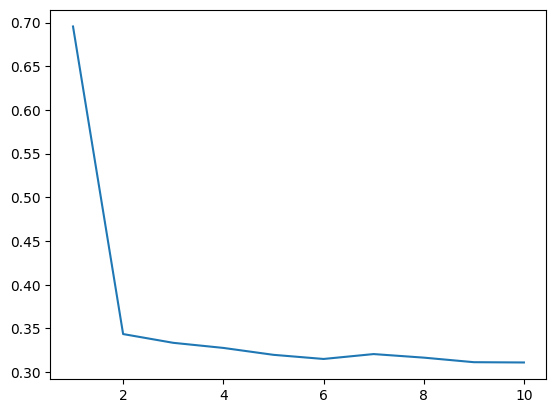

In [ ]:
train_epoch_loss = np.array(train_epoch_loss)
train_batch_loss = np.array(train_batch_loss)


np.savez('train_loss.npz', train_epoch_loss=train_epoch_loss, train_batch_loss=train_batch_loss)

loaded_array = np.load('train_loss.npz')

plt.plot(np.arange(1, 11), loaded_array["train_epoch_loss"])

#plt.plot(np.arange(1, 801), loaded_array["train_batch_loss"])

In [ ]:
model_file = "./weights-train.pth"

torch.save(model.state_dict(), model_file)

model.load_state_dict(torch.load(model_file))
model.eval()

ECCVGenerator(
  (model1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=Tru

In [ ]:
(prediction*(127+128) -128).max()

tensor(22.4947, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
data = next(iter(train_dataloader))
lab_data = rgb_to_lab(data[0])

L_data = lab_data[:, 0, :, :].unsqueeze(1).to(device)
L_data = (L_data)/100
AB_data = lab_data[:, 1:, :, :].to(device)


AB_predicted = model(L_data).to(device)
AB_predicted = AB_predicted*(127+128) - 128
L_data = L_data*100

img_prediction = torch.cat((L_data, AB_predicted), dim=1)

sample_rgb_prediction = lab_to_rgb(img_prediction)[0]
sample_rgb_original = lab_to_rgb(lab_data)[0]


In [ ]:
data[1][0]

'bridge479'

In [ ]:
print((AB_predicted).max())

tensor(6.3739, device='cuda:0', grad_fn=<MaxBackward1>)


(-0.5, 255.5, 255.5, -0.5)

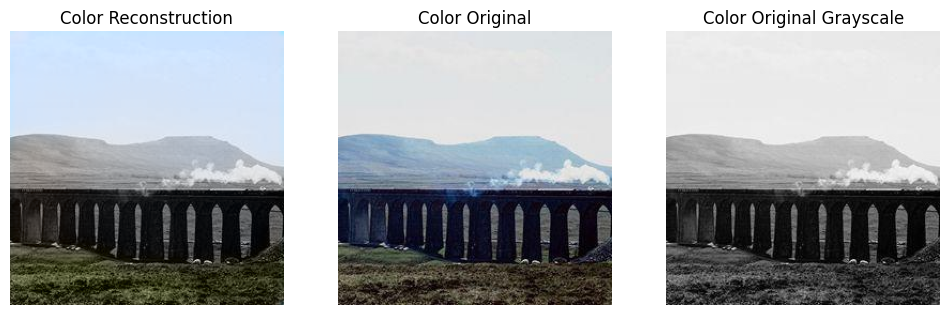

In [ ]:
sample_rgb_prediction = sample_rgb_prediction.cpu().detach()

img_sample = np.transpose(sample_rgb_prediction, (1, 2, 0)).numpy()

#img_sample = img_sample.numpy()

img_or = Image.open("./train-split/bridge479")



plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_sample)
plt.title('Color Reconstruction')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_or)
plt.title('Color Original')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(color.rgb2gray(img_or), cmap="gray")
plt.title('Color Original Grayscale')
plt.axis("off")

In [ ]:
sample_rgb_original.shape

torch.Size([3, 256, 256])

In [ ]:
imag_sample = np.transpose(RGB, (1, 2, 0))

img_original = next(iter(dataloader))[0].cpu().numpy()
img_original = np.transpose(img_original, (1, 2, 0))

img_original = Image.open('./SUN-dataset/amphitheater127')
img_original = img_original.resize((256, 256))

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(imag_sample)
plt.title('Color Reconstruction')

plt.subplot(1, 2, 2)
plt.imshow(img_original)
plt.title('Original Color Image')



In [ ]:
lab_data = rgb_to_lab(data[0])
L_data = lab_data[:, 0, :, :].unsqueeze(1).to(device)
AB_data = lab_data[:, 1:, :, :].to(device)



AB_predicted = model(L_data)
img_prediction = torch.cat((L_test, AB_predicted), dim=1)



In [ ]:
AB_predicted.shape

torch.Size([51, 2, 256, 256])

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.layers = nn.Sequential(
            #Conv1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),

            #Conv2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),

            #Conv3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),

            #Conv4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(128),

            #Conv5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(256),

            #Conv6
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(128),

            #Conv7
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),

            #Conv8
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(32),

            #Conv9
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(inplace=True),

            #Conv10
            nn.Conv2d(in_channels=16, out_channels=2, kernel_size=3, padding=1, stride=1),
            nn.Tanh(),
        )


    def forward(self, x):
        return self.layers(x)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage:
# Instantiate your PyTorch model
total_params = count_parameters(model)

print(total_params)

781474


In [ ]:
print(model)

CNNModel(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): C

In [ ]:
def lab_to_rgb(img_l, img_ab):
    """
    Convert a pair of numpy arrays (l channel and ab channels) into an rgb image
    :param img_l:
    :return:
    """
    lab = np.empty([*img_l.shape[0:2], 3])
    lab[:, :, 0] = np.squeeze(((img_l + 1) * 50))
    lab[:, :, 1:] = img_ab * 127
    return color.lab2rgb(lab)

def rgb_to_lab(img):
    lab = color.rgb2lab(img).astype(np.float32)
    L =  np.expand_dims(lab[:,:,0], axis=2)
    L = 2 * L / 100 - 1
    AB = lab[:, :, 1:].transpose(2,0,1) / 127
    return L,AB

def get_image_class(filename):
    pattern = r'[0-9]'
    return re.sub(pattern, '', filename)

In [ ]:

epochs = 5

train_batch_loss = []
train_epoch_loss = []


for epoch in range(epochs):
    train_total_loss = 0
#    val_total_loss = 0
    print("Epoch:", epoch+1)
    model.train()
    # Train
    for batch_idx,data in enumerate(dataloader):
        print("batch_idx")
        # Move Data to GPU

        lab_data = rgb_to_lab(data)

        L_data = lab_data[:, 0, :, :].unsqueeze(1).to(device)
        L_data = (2*L_data)/100 -1
        AB_data = lab_data[:, 1:, :, :].to(device)
        AB_data = AB_data/127

        # Init. Optim. Params.
        optimizer.zero_grad()

        # Get Network AB
        prediction = model(L_data)

        loss = criterion(prediction, AB_data)

        # Back Prop.
        loss.backward()

        # Update Weights
        optimizer.step()

        # Update Loss Saves
        train_batch_loss.append(loss.item())
        train_total_loss += loss.item()

    train_epoch_loss.append(train_total_loss)

    # Print Info Every Epoch
    print("Train Loss: ", train_total_loss)
    # print("Val. Loss: ", val_total_loss)

Epoch: 1
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
batch_idx
b

In [ ]:
#train_epoch_loss = np.array(train_epoch_loss)

#np.save('train_epoch_loss.npy', train_epoch_loss)

loaded_array = np.load('train_epoch_loss(1).npy')


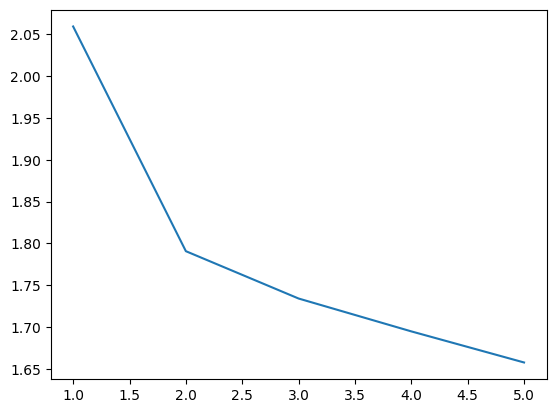

In [ ]:
plt.plot(np.arange(1, 6), loaded_array)

In [ ]:
torch.save(model.state_dict(), "weights.pth")

In [ ]:
model.load_state_dict(torch.load("./weights(1).pth"))
model.eval()

CNNModel(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): C

In [ ]:
next(iter(dataloader))[0].shape

torch.Size([3, 256, 256])

In [ ]:
lab_test.shape

torch.Size([3, 256, 256])

In [ ]:
lab_test = rgb_to_lab(next(iter(dataloader)))

L_test = ( (2*lab_test[:, 0, :, :])/100  - 1).unsqueeze(1).to(device)
AB_test = ((lab_test[:, 1:, :, :])/127).unsqueeze(1).to(device)

In [ ]:
AB_predicted = model(L_test)*127
L_test = (L_test + 1)*50

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 427.06 MiB is free. Process 25162 has 14.33 GiB memory in use. Of the allocated memory 13.32 GiB is allocated by PyTorch, and 900.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
L_test = (L_test + 1)*50

In [ ]:
LAB_img_predicted = torch.cat((L_test, AB_predicted), dim=1)
RGB_img_predicted = lab_to_rgb(LAB_img_predicted)
RGB_img = RGB_img_predicted[0].detach()


In [ ]:
RGB_img.shape

torch.Size([3, 256, 256])

In [ ]:
RGB_img[1, :, :].max()

tensor(0.8036, device='cuda:0')

In [ ]:
next(iter(dataloader))[0].

torch.Size([3, 256, 256])

In [ ]:
RGB = RGB_img.cpu().numpy()

In [ ]:
img_original = next(iter(dataloader))[0]

In [ ]:
img_original.cpu().numpy()

array([[[0.46666667, 0.47058824, 0.4745098 , ..., 0.5294118 ,
         0.5294118 , 0.5294118 ],
        [0.47058824, 0.4745098 , 0.47843137, ..., 0.53333336,
         0.53333336, 0.5294118 ],
        [0.47058824, 0.4745098 , 0.47843137, ..., 0.5372549 ,
         0.5372549 , 0.53333336],
        ...,
        [0.39215687, 0.4       , 0.40392157, ..., 0.31764707,
         0.32156864, 0.32156864],
        [0.39607844, 0.4       , 0.4117647 , ..., 0.32156864,
         0.32156864, 0.31764707],
        [0.40392157, 0.40784314, 0.4117647 , ..., 0.3254902 ,
         0.32941177, 0.32156864]],

       [[0.6       , 0.6039216 , 0.60784316, ..., 0.6392157 ,
         0.6392157 , 0.6392157 ],
        [0.6039216 , 0.60784316, 0.6117647 , ..., 0.6431373 ,
         0.6431373 , 0.6392157 ],
        [0.6039216 , 0.60784316, 0.6117647 , ..., 0.64705884,
         0.64705884, 0.64705884],
        ...,
        [0.39607844, 0.40392157, 0.40784314, ..., 0.31764707,
         0.31764707, 0.31764707],
        [0.4

Text(0.5, 1.0, 'Original Color Image')

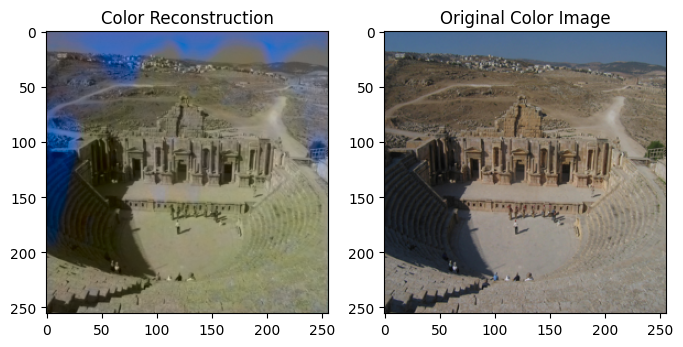

In [ ]:
imag_sample = np.transpose(RGB, (1, 2, 0))

img_original = next(iter(dataloader))[0].cpu().numpy()
img_original = np.transpose(img_original, (1, 2, 0))

img_original = Image.open('./SUN-dataset/amphitheater127')
img_original = img_original.resize((256, 256))

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(imag_sample)
plt.title('Color Reconstruction')

plt.subplot(1, 2, 2)
plt.imshow(img_original)
plt.title('Original Color Image')



# Import Images

In [ ]:
from concurrent.futures import ThreadPoolExecutor

In [ ]:
class ModelData(Dataset):

    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.data = os.listdir(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_name = self.data[idx]
        file_path = os.path.join(self.folder_path, file_name)
        image = io.imread(file_path)
        image_enc = resize(image, (256, 256))

        L, AB = rgb_to_lab(image_enc)

        L = np.repeat(L,1,axis=2).transpose(2,0,1).astype(np.float32)


        # Build Sample Dict.
        sample = {"L":L, "AB":AB, "RGB": image_enc, "label" : get_image_class(file_name)}

        return sample

In [ ]:
dataset[0]["RGB"].shape

(256, 256, 3)

In [ ]:
dataloader["L"].shape

TypeError: 'DataLoader' object is not subscriptable

In [ ]:
for batch_idx, data in enumerate(dataloader):
  print(data["L"].shape)


torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])


KeyboardInterrupt: 

In [ ]:
epochs = 10

train_batch_loss = []
train_epoch_loss = []

for epoch in range(epochs):

    train_total_loss = 0
    print("Epoch:", epoch+1)
    model.train()
    # Train
    for batch_idx, data in enumerate(dataloader):
        print(batch_idx)
        # Move Data to GPU
        L_train = data["L"].to(device)
        AB_train = data["AB"].to(device)

        # Init. Optim. Params.
        optimizer.zero_grad()
        # Get Inception Output

        # Get Network AB
        prediction = model(L_train)

        # Determine Loss
        loss = criterion(prediction, AB_train)

        # Back Prop.
        loss.backward()

        # Update Weights
        optimizer.step()

        # Update Loss Saves
        train_batch_loss.append(loss.item())
        train_total_loss += loss.item()

    train_epoch_loss.append(train_total_loss)

    # Print Info Every Epoch
    print("Train Loss: ", train_total_loss)
    # print("Val. Loss: ", val_total_loss)

Epoch: 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


KeyboardInterrupt: 

# CNN Simple Model

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb  5 14:04:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              42W / 300W |    330MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!mkdir SUN-dataset-test

! cp ./SUN-dataset/apartment_building1 ./SUN-dataset-test/

In [ ]:
test_folder = "./SUN-dataset-test/"

dataset = ModelData(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)



In [ ]:
RGB_img_predicted = RGB_img_predicted.numpy()

In [ ]:
RGB_img_predicted = RGB_img_predicted.cpu().detach()

In [ ]:
next(iter(dataloader)).shape

torch.Size([1, 3, 256, 256])

In [ ]:
lab_test[:, 2, :, :].min()

tensor(-19.2527)

In [ ]:
RGB_img_predicted.max()

0.1685707

In [ ]:
RGB_img_predicted[0].shape

(3, 256, 256)

Text(0.5, 1.0, 'Original Color Image')

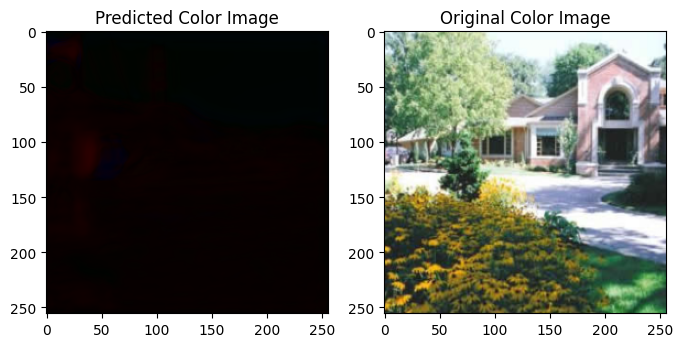

In [ ]:
imag_sample_test = np.transpose((RGB_img_predicted[0]), (1, 2, 0))

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(imag_sample_test)
plt.title('Predicted Color Image')

imag_sample = dataset[1].permute(1, 2, 0)

plt.subplot(1, 2, 2)
plt.imshow(imag_sample)
plt.title('Original Color Image')
